In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 6 2021

@authors: R. van Hoof & A. Lozano
"""

# %matplotlib inline

'\nCreated on Wed May 6 2021\n\n@authors: Rick van Hoof & Antonio Lozano\n'

In [2]:
import time
import os.path
import pickle # needed to store the results
from copy import deepcopy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score as MI
from skopt.utils import use_named_args
from skopt.space import Integer, Categorical, Real
from skopt.utils import cook_initial_point_generator
from skopt import gp_minimize

########################
### Custom functions ###
########################
from ninimplant import pol2cart, get_xyz # matrix rotation/translation ect
from lossfunc import DC, KL, get_yield, hellinger_distance
from electphos import create_grid, reposition_grid, implant_grid, get_phosphenes, prf_to_phos, prf_to_phos_v1, gen_dummy_phos, get_cortical_magnification, cortical_spread
import visualsectors as gvs

# ignore "True-divide" warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
##########
## INIT ##
##########

# datafolder = '/path/to/data/'
# outputfolder = '/path/to/data/'
datafolder = 'F:/Rick/Surfdrive_BACKUP/Data/NESTOR/HCP/subjects/'
outputfolder = 'C:/nestor/temp/'

# determine range of parameters used in optimization
dim1 = Integer(name='alpha', low=-90, high=90) # visual degrees 
dim2 = Integer(name='beta', low=-15, high=110) # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
dim3 = Integer(name='offset_from_base', low=0, high=40) # in mm
dim4 = Integer(name='shank_length', low=10, high=40) # mm
dimensions = [dim1, dim2, dim3, dim4]

num_calls = 150
x0 = (0,0,20,25) # initial values for the four dimensions
num_initial_points = 10
dc_percentile = 50
n_contactpoints_shank = 10
spacing_along_xy = 1
WINDOWSIZE = 1000

# lists of loss term combinations to loop through
    # Dice Coefficient (1, 0, 0)
    # Yield (0, 1, 0)
    # Hellinger Distance (0, 0, 1)
loss_comb = ([(1, 0.1, 1)]) # weights for loss terms
loss_names = (['dice-yield-HD']) # substring in output filename

# lists of target maps to loop through
targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False), 
              gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
              gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=400, radiusLow=0, radiusHigh=250, plotting=False),
              gvs.complete_gauss(windowsize=1000, fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)])
targ_names = (['targ-upper', 'targ-lower', 'targ-inner', 'targ-full'])

# constants pRF model
cort_mag_model = 'wedge-dipole' # which cortex model to use for the cortical magnification
view_angle = 90 #in degrees of visual angle
amp = 100 #stimulation amplitude in micro-amp (higher stimulation -> more tissue activated)

# INIT Bayes
amax = 1
bmax = 1
cmax = 1000
N=5
delta=0.2
thresh=0.05

# subjects to include
subj_list = [118225, 144226, 162935, 176542, 187345, 200614, 251833, 389357, 547046, 671855, 789373, 901139,  
100610, 125525, 145834, 164131, 177140, 191033, 201515, 257845, 393247, 550439, 680957, 814649, 901442, 
102311, 126426, 146129, 164636, 177645, 191336, 203418, 263436, 395756, 552241, 690152, 818859, 905147, 
102816, 128935, 146432, 165436, 177746, 191841, 204521, 283543, 397760, 562345, 706040, 825048, 910241, 
104416, 130114, 146735, 167036, 178142, 192439, 205220, 318637, 401422, 572045, 724446, 826353, 926862, 
105923, 130518, 146937, 167440, 178243, 192641, 209228, 320826, 406836, 573249, 725751, 833249, 927359, 
108323, 131217, 148133, 169040, 178647, 193845, 212419, 330324, 412528, 581450, 732243, 859671, 942658, 
109123, 131722, 150423, 169343, 180533, 195041, 214019, 346137, 429040, 585256, 751550, 861456, 943862, 
111312, 132118, 155938, 169444, 181232, 196144, 214524, 352738, 436845, 601127, 757764, 871762, 951457, 
111514, 134627, 156334, 169747, 181636, 197348, 221319, 360030, 463040, 617748, 765864, 872764, 958976, 
114823, 134829, 157336, 171633, 182436, 198653, 233326, 365343, 467351, 627549, 770352, 878776, 966975, 
115017, 135124, 158035, 172130, 182739, 199655, 239136, 380036, 525541, 638049, 771354, 878877, 971160, 
115825, 137128, 158136, 173334, 185442, 200210, 246133, 381038, 536647, 644246, 782561, 898176, 973770, 
116726, 140117, 159239, 175237, 186949, 200311, 249947, 385046, 541943, 654552, 783462, 899885, 995174, 'fsaverage']

In [6]:
################################################
## Functions related to Bayesian optimization ##
################################################

def custom_stopper(res, N=5, delta=0.2, thresh=0.05):
    '''
    Returns True (stops the optimization) when 
    the difference between best and worst of the best N are below delta AND the best is below thresh
    
    N = last number of cost values to track
    delta = ratio best and worst
    
    '''
    
    if len(res.func_vals) >= N:
        func_vals = np.sort(res.func_vals)
        worst = func_vals[N - 1]
        best = func_vals[0]
        
        return (abs((best - worst)/worst) < delta) & (best < thresh)
    else:
        return None

@use_named_args(dimensions=dimensions)
def f(alpha, beta, offset_from_base, shank_length):
    """
    This function encapsulates the electrode placement procedure and returns the cost value by 
    comparing the resulting phosphene map with the target map.    
    * First it creats a grid based on the four parameters. 
    * Phosphenes are generated based on the grid's contact points, 
      and their sizes are determined using cortical magnification and spread values. 
    * These phosphenes are converted into a 2D image representation. 
      The function then computes the dice coefficient and yield, and calculates the Hellinger 
      distance between the generated image and a target density. 
    * The resulting cost is a combination of these factors, 
      with penalties applied if the grid is invalid. 
    * The function also handles cases of invalid values and prints diagnostic information. 
    * Ultimately, the function returns the calculated cost used by the bayesopt algorithm.
    """
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)    
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)
    
    # implanting grid
    _, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)    
    phosphenes = get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)   
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model) 
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image    
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32') 
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)    
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()

    # bin_thesh determines size target
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) 

    # compute dice coefficient -> should be 1 -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)

    # compute hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())    
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    print('    ', "{:.2f}".format(cost), "{:.2f}".format(dice), "{:.2f}".format(grid_yield), "{:.2f}".format(par3), grid_valid)
    return cost

def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density):
    '''
    Copy from f, to obtain phosphene map and contact points for the optimized parameters. Used to visualize results.

    also returns coords used ect.
    '''
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)

    # implanting grid
    ref_contacts_xyz, contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints in each ROI (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    phosphenes =    get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model)
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32')
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    print(view_angle)
    
    # can we relate bin_thesh to an eccentricity value? -> taken care of by masking the targets -> CHANGE TO 0.99999
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) # bin_thesh determines size target

    # compute dice coefficient -> should be large -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)  
    
    # very important to normalize target density to same range as phospheneMap!
    target_density /= target_density.max()
    target_density /= target_density.sum()        
    
    # compute Hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    return grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap

number of subjects: 2
target:  targ-upper
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.67 0.18 0.58 0.90 True
     3.57 0.07 0.36 0.92 False
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.46 1.00 False
map is nan or 0
Hellington is nan or inf
     2.98 0.00 0.25 1.00 True
     3.56 0.08 0.30 0.93 False
     3.62 0.05 0.27 0.95 False
     2.46 0.33 0.39 0.84 True
     2.77 0.10 0.54 0.93 True
     2.79 0.08 0.53 0.93 True
     3.50 0.11 0.62 0.92 False
     3.58 0.07 0.49 0.95 False
     3.53 0.10 0.49 0.93 False
     2.60 0.22 0.44 0.87 True
     3.58 0.07 0.23 0.93 False
     2.57 0.27 0.36 0.87 True
     3.63 0.04 0.55 0.97 False
     2.48 0.31 0.44 0.83 True
     2.41 0.39 0.47 0.85 True
     2.91 0.03 0.23 0.97 True
     2.67 0.20 0.42 0.92 True
     2.59 0.27 0.44 0.90 True
     2.64 0.22 0.44 0.90 True
     2.41 0.40 0.48 0.85 True
     2.45 0.33 0.49 0.83 True
     2.35 0.44 0.37 0.83 True
     2.98 0.00 0.16 1.00 True
     3.58 0.06 0.48 0.94 False
     2.48 0.36 0.37

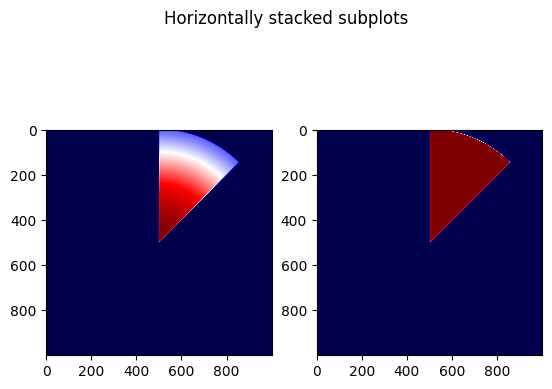

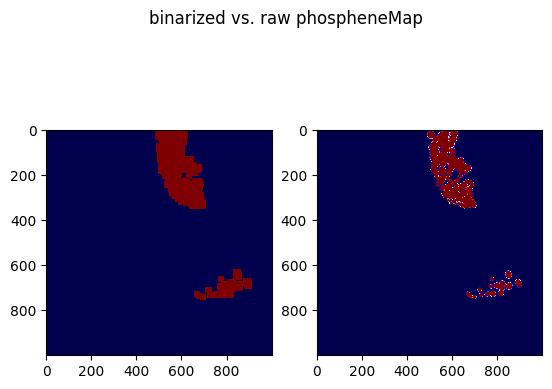

    max phospheneMap:  0.00016903898
     2.73 0.16 0.54 0.94 True
     3.70 0.01 0.40 1.00 False
     2.88 0.05 0.47 0.98 True
     2.93 0.02 0.37 0.99 True
     3.69 0.01 0.48 1.00 False
     3.70 0.02 0.10 0.98 False
     2.98 0.00 0.19 1.00 True
     3.51 0.12 0.30 0.91 False
     2.97 0.00 0.27 1.00 True
     2.96 0.00 0.30 1.00 True
     2.94 0.02 0.34 0.99 True
     2.91 0.05 0.25 0.98 True
     2.93 0.01 0.42 0.99 True
     3.69 0.02 0.20 0.98 False
     2.64 0.22 0.50 0.92 True
     2.85 0.09 0.34 0.97 True
     3.58 0.05 0.46 0.92 False
map is nan or 0
Hellington is nan or inf
     2.99 0.00 0.08 1.00 True
     2.93 0.01 0.48 0.99 True
map is nan or 0
Hellington is nan or inf
     2.95 0.00 0.50 1.00 True
     3.70 0.00 0.39 1.00 False
     2.89 0.03 0.55 0.98 True
     2.66 0.21 0.50 0.92 True
     3.66 0.03 0.46 0.98 False
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.51 1.00 False
     2.64 0.24 0.46 0.93 True
     2.71 0.18 0.43 0.94 True
     2.98 0.00 0.25 1

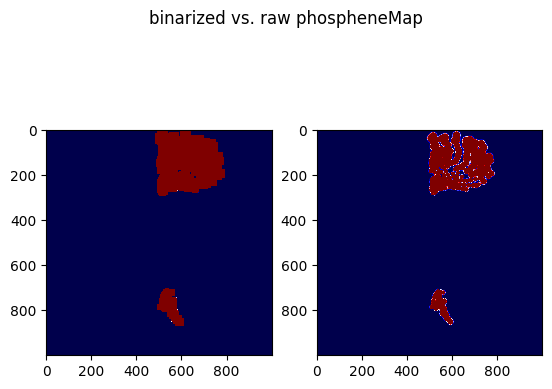

    max phospheneMap:  0.00010342363
target:  targ-upper
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.75 0.14 0.48 0.93 True
     3.50 0.10 0.54 0.90 False
     3.61 0.05 0.32 0.95 False
     2.68 0.15 0.47 0.88 True
     2.73 0.12 0.40 0.89 True
     2.36 0.42 0.45 0.83 True
     3.55 0.09 0.32 0.92 False
     3.60 0.06 0.18 0.92 False
     2.78 0.09 0.41 0.91 True
     2.89 0.07 0.17 0.97 True
map is nan or 0
Hellington is nan or inf
     3.69 0.00 0.56 1.00 False
     2.31 0.44 0.12 0.76 True
     3.52 0.11 0.26 0.90 False
     2.07 0.62 0.23 0.72 True
     3.67 0.01 0.53 0.99 False
     2.02 0.65 0.26 0.70 True
     2.74 0.10 0.61 0.90 True
     2.16 0.54 0.28 0.73 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.40 1.00 False
     2.03 0.64 0.39 0.71 True
     2.88 0.04 0.35 0.95 True
     2.00 0.69 0.13 0.71 True
     3.39 0.21 0.52 0.90 False
     2.99 0.00 0.07 1.00 True
     1.92 0.74 0.19 0.68 True
     1.95 0.72 0.18 0.69 True
     1.90 0.74 0.19 0.66 True
     

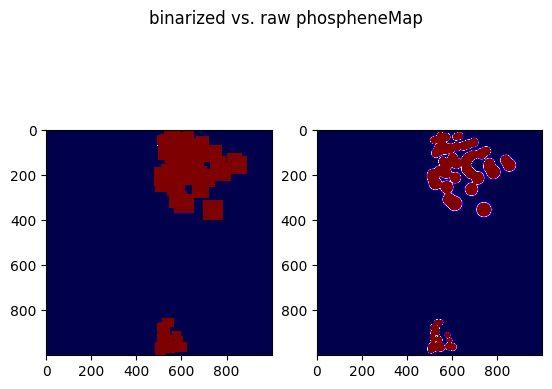

    max phospheneMap:  0.00014897592
     2.65 0.21 0.45 0.91 True
     3.66 0.03 0.43 0.98 False
     3.64 0.04 0.32 0.96 False
     2.83 0.05 0.58 0.94 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.38 1.00 False
     3.56 0.09 0.53 0.94 False
map is nan or 0
Hellington is nan or inf
     2.98 0.00 0.23 1.00 True
     2.98 0.00 0.20 1.00 True
     3.65 0.04 0.21 0.96 False
     2.89 0.03 0.46 0.97 True
     3.70 0.02 0.05 0.97 False
     2.89 0.03 0.47 0.97 True
map is nan or 0
Hellington is nan or inf
     2.99 0.00 0.12 1.00 True
     3.65 0.04 0.21 0.96 False
     3.68 0.01 0.25 0.96 False
map is nan or 0
Hellington is nan or inf
     3.72 0.00 0.29 1.00 False
     2.78 0.11 0.47 0.94 True
     2.46 0.36 0.35 0.86 True
     2.70 0.20 0.28 0.93 True
     2.57 0.30 0.18 0.88 True
     3.61 0.06 0.30 0.95 False
     2.47 0.37 0.10 0.85 True
     2.50 0.33 0.10 0.84 True
     2.50 0.34 0.10 0.86 True
     2.56 0.30 0.09 0.87 True
     2.76 0.15 0.07 0.92 True
     3.65

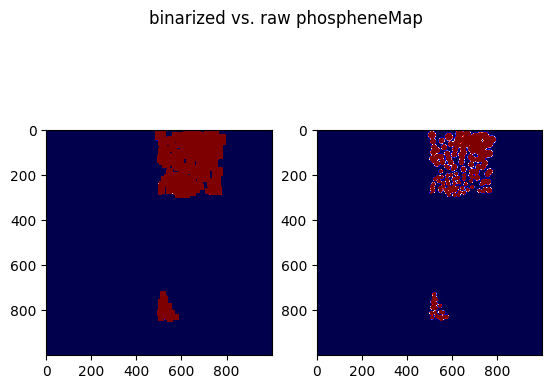

    max phospheneMap:  0.00019271701
target:  targ-lower
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.77 0.12 0.58 0.95 True
map is nan or 0
Hellington is nan or inf
     3.00 0.00 0.02 1.00 True
     3.58 0.08 0.48 0.95 False
     3.71 0.01 0.26 1.00 False
     2.94 0.01 0.49 0.99 True
     2.99 0.00 0.14 1.00 True
     2.94 0.01 0.41 0.99 True
     3.71 0.01 0.24 0.99 False
     3.72 0.00 0.34 1.00 False
     3.69 0.01 0.36 0.99 False
     3.74 0.00 0.13 1.00 False
     2.90 0.03 0.57 0.99 True
     2.90 0.02 0.66 0.99 True
     2.83 0.07 0.59 0.95 True
     2.89 0.03 0.53 0.98 True
     2.93 0.02 0.24 0.98 True
map is nan or 0
Hellington is nan or inf
     2.95 0.00 0.51 1.00 True
     3.71 0.00 0.43 1.00 False
     3.54 0.10 0.49 0.94 False
     2.41 0.39 0.52 0.85 True
     2.98 0.00 0.20 1.00 True
     2.93 0.01 0.48 0.99 True
map is nan or 0
Hellington is nan or inf
     3.00 0.00 0.04 1.00 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.38 1.00 False
     2.99 0.0

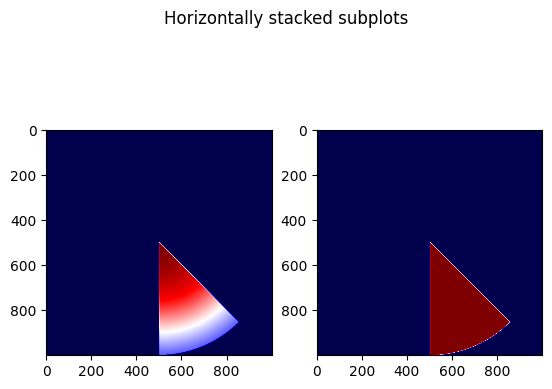

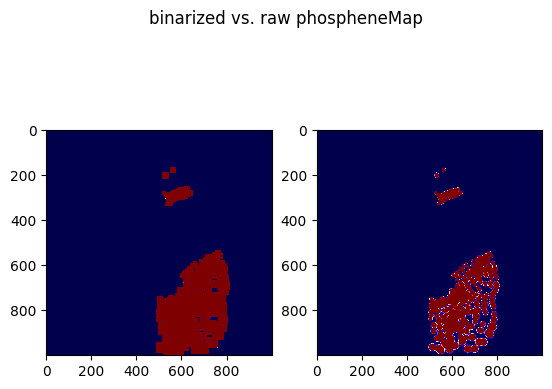

    max phospheneMap:  0.00011113956
     2.65 0.21 0.54 0.92 True
     3.38 0.21 0.29 0.87 False
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.51 1.00 False
     3.59 0.08 0.20 0.94 False
     3.73 0.00 0.19 1.00 False
     2.96 0.01 0.23 0.99 True
     2.79 0.09 0.45 0.93 True
     2.85 0.06 0.43 0.95 True
     2.94 0.02 0.17 0.97 True
     3.53 0.11 0.38 0.93 False
     3.51 0.12 0.16 0.89 False
     2.96 0.01 0.17 0.99 True
     3.51 0.11 0.38 0.91 False
     2.95 0.00 0.45 1.00 True
     2.70 0.17 0.26 0.90 True
     2.86 0.06 0.48 0.96 True
     3.59 0.06 0.43 0.95 False
     2.52 0.30 0.56 0.88 True
     2.84 0.08 0.51 0.97 True
     2.68 0.19 0.54 0.92 True
     2.80 0.09 0.48 0.93 True
     3.58 0.05 0.47 0.92 False
     2.87 0.05 0.46 0.97 True
     2.89 0.04 0.38 0.96 True
     2.32 0.42 0.64 0.80 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.38 1.00 True
     2.57 0.25 0.61 0.89 True
     2.95 0.02 0.23 0.99 True
     2.23 0.49 0.57 0.77 True
  

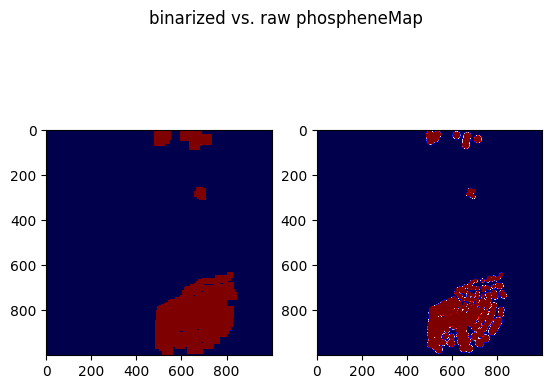

    max phospheneMap:  0.00010117795
target:  targ-lower
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.70 0.18 0.48 0.93 True
     3.65 0.03 0.44 0.98 False
     2.96 0.00 0.39 1.00 True
     2.95 0.00 0.47 1.00 True
     3.54 0.10 0.27 0.92 False
     3.71 0.00 0.44 1.00 False
     2.97 0.00 0.33 1.00 True
     3.70 0.01 0.30 0.99 False
     3.72 0.00 0.35 1.00 False
     3.75 0.00 0.01 1.00 False
     2.96 0.00 0.34 1.00 True
     2.99 0.00 0.12 1.00 True
     3.70 0.01 0.30 0.99 False
     2.95 0.00 0.45 1.00 True
     2.50 0.34 0.46 0.89 True
     2.75 0.16 0.38 0.95 True
     2.91 0.03 0.55 0.99 True
     2.94 0.00 0.56 1.00 True
     2.98 0.00 0.17 1.00 True
     2.52 0.32 0.37 0.87 True
     2.84 0.08 0.53 0.97 True
     2.61 0.27 0.30 0.90 True
     2.51 0.32 0.37 0.86 True
     2.56 0.29 0.51 0.91 True
     2.60 0.26 0.47 0.91 True
     2.61 0.26 0.41 0.91 True
     2.51 0.35 0.24 0.88 True
     3.57 0.09 0.06 0.92 False
     2.57 0.30 0.33 0.90 True
     2.68 0.22 0.28 0.93 Tru

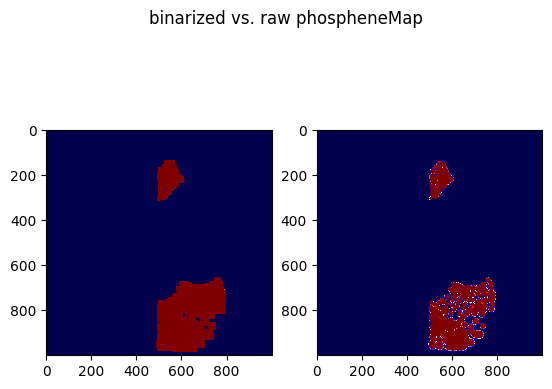

    max phospheneMap:  0.00010528541
     2.81 0.10 0.45 0.95 True
     3.61 0.05 0.26 0.94 False
     3.51 0.10 0.49 0.92 False
map is nan or 0
Hellington is nan or inf
     2.99 0.00 0.07 1.00 True
     3.63 0.04 0.20 0.95 False
     3.64 0.04 0.09 0.94 False
     2.97 0.00 0.32 1.00 True
     2.70 0.15 0.54 0.91 True
     2.71 0.18 0.33 0.93 True
map is nan or 0
Hellington is nan or inf
     3.74 0.00 0.13 1.00 False
     3.63 0.05 0.27 0.96 False
     2.78 0.09 0.59 0.92 True
     2.94 0.02 0.13 0.98 True
     3.68 0.01 0.36 0.98 False
     2.70 0.15 0.51 0.91 True
     2.68 0.21 0.30 0.92 True
     3.48 0.15 0.47 0.92 False
     2.70 0.19 0.26 0.92 True
     2.92 0.01 0.52 0.98 True
     3.64 0.04 0.36 0.97 False
     2.68 0.21 0.29 0.92 True
     2.98 0.00 0.22 1.00 True
     2.60 0.26 0.31 0.89 True
     2.50 0.32 0.34 0.85 True
     2.40 0.37 0.43 0.81 True
     2.47 0.32 0.40 0.83 True
     2.37 0.38 0.46 0.80 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.32 1

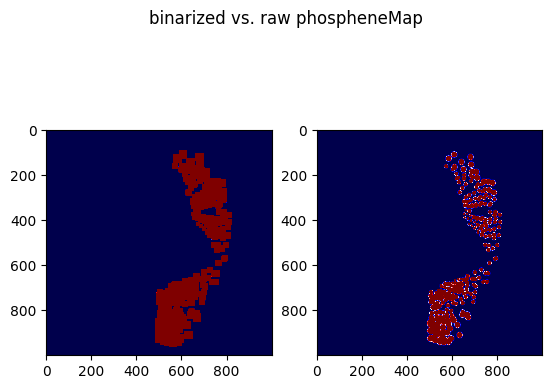

    max phospheneMap:  0.00018499665
target:  targ-inner
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.59 0.24 0.58 0.89 True
     3.40 0.17 0.29 0.86 False
     2.63 0.20 0.23 0.85 True
     2.97 0.00 0.25 1.00 True
     2.71 0.14 0.21 0.87 True
     2.51 0.24 0.60 0.80 True
     3.40 0.18 0.24 0.85 False
     2.86 0.05 0.21 0.92 True
     3.59 0.07 0.10 0.91 False
     2.59 0.24 0.29 0.86 True
     3.57 0.06 0.30 0.91 False
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.27 1.00 True
     3.35 0.18 0.61 0.84 False
     2.61 0.17 0.52 0.83 True
     2.53 0.23 0.57 0.81 True
     2.66 0.15 0.57 0.86 True
map is nan or 0
Hellington is nan or inf
     3.00 0.00 0.00 1.00 True
     2.35 0.36 0.60 0.77 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.27 1.00 True
     2.88 0.04 0.29 0.94 True
     2.34 0.37 0.56 0.77 True
     3.00 0.00 0.03 1.00 True
     2.89 0.02 0.47 0.95 True
     2.73 0.14 0.22 0.88 True
     2.54 0.25 0.47 0.83 True
     2.27 0.43 0.66 0.76 Tru

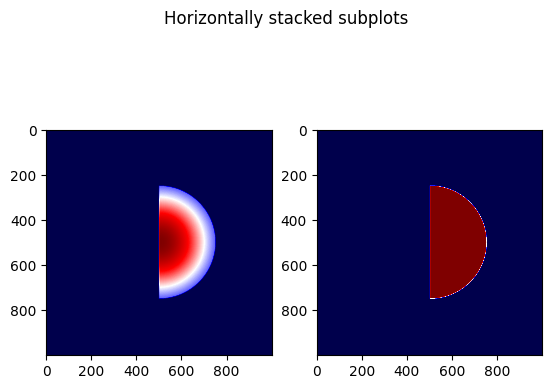

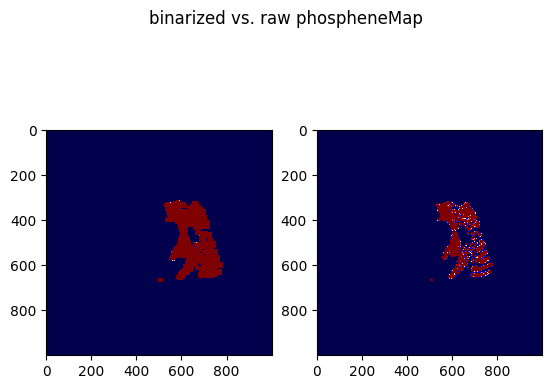

    max phospheneMap:  0.00036491672
     2.72 0.16 0.54 0.94 True
     3.62 0.03 0.45 0.94 False
     3.40 0.20 0.17 0.87 False
     2.76 0.12 0.19 0.91 True
     2.89 0.08 0.08 0.97 True
     2.61 0.22 0.31 0.86 True
     2.34 0.43 0.55 0.83 True
     2.76 0.14 0.33 0.93 True
     3.31 0.24 0.44 0.85 False
     3.22 0.32 0.34 0.81 False
     3.56 0.09 0.10 0.91 False
     2.27 0.46 0.50 0.78 True
     2.39 0.37 0.39 0.80 True
     2.98 0.00 0.21 1.00 True
     2.86 0.08 0.26 0.97 True
     2.26 0.47 0.52 0.78 True
     2.44 0.31 0.42 0.79 True
     2.25 0.48 0.52 0.77 True
     2.24 0.47 0.55 0.77 True
     2.26 0.46 0.53 0.77 True
     2.25 0.46 0.55 0.77 True
     2.24 0.46 0.59 0.77 True
     2.22 0.49 0.59 0.77 True
     3.51 0.12 0.29 0.91 False
     2.97 0.50 0.60 0.78 False
     2.21 0.50 0.59 0.77 True
     2.22 0.49 0.58 0.77 True
     2.96 0.51 0.59 0.78 False
     2.38 0.39 0.53 0.83 True
     2.23 0.49 0.60 0.78 True
     2.22 0.49 0.57 0.77 True
     2.21 0.51 0.55 0.77 

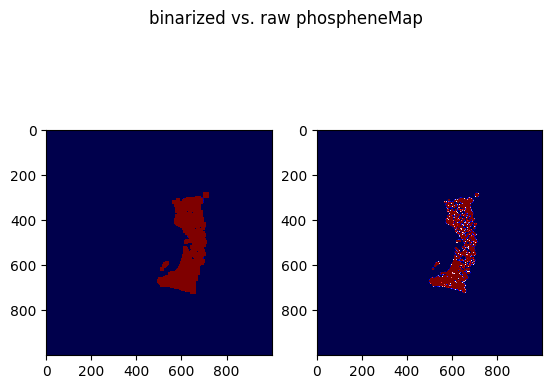

    max phospheneMap:  0.00046272986
target:  targ-inner
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.73 0.16 0.48 0.94 True
     2.56 0.23 0.49 0.84 True
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.46 1.00 False
     2.38 0.36 0.56 0.79 True
     3.32 0.22 0.37 0.83 False
     3.23 0.30 0.39 0.82 False
     2.44 0.31 0.55 0.81 True
     3.34 0.22 0.38 0.84 False
     3.38 0.20 0.26 0.85 False
     3.59 0.07 0.13 0.92 False
     3.44 0.19 0.20 0.90 False
     2.89 0.02 0.37 0.95 True
map is nan or 0
Hellington is nan or inf
     3.74 0.00 0.06 1.00 False
     2.78 0.07 0.57 0.90 True
     2.45 0.31 0.48 0.81 True
     2.47 0.33 0.58 0.85 True
     2.62 0.19 0.47 0.86 True
     3.26 0.25 0.51 0.81 False
     2.58 0.20 0.54 0.83 True
     2.46 0.32 0.51 0.83 True
     2.79 0.10 0.28 0.91 True
     2.50 0.28 0.42 0.82 True
     2.41 0.37 0.53 0.83 True
     2.36 0.38 0.56 0.80 True
     2.35 0.38 0.57 0.79 True
     2.34 0.39 0.57 0.78 True
     2.38 0.35 0.56 0.79 True
     

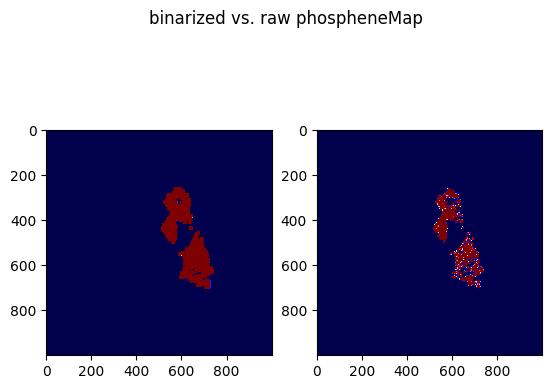

    max phospheneMap:  0.00047195525
     2.75 0.14 0.45 0.93 True
     3.18 0.34 0.43 0.81 False
     3.55 0.10 0.17 0.92 False
     3.40 0.18 0.29 0.86 False
     2.77 0.10 0.18 0.90 True
     2.37 0.38 0.58 0.80 True
     3.45 0.15 0.32 0.88 False
     2.71 0.15 0.26 0.88 True
     2.98 0.00 0.19 1.00 True
     2.81 0.07 0.32 0.92 True
     3.65 0.03 0.13 0.95 False
     3.16 0.35 0.57 0.81 False
     2.83 0.06 0.30 0.92 True
     2.41 0.34 0.53 0.81 True
     3.59 0.04 0.55 0.93 False
     2.98 0.00 0.23 1.00 True
     2.46 0.31 0.52 0.82 True
     2.65 0.17 0.44 0.87 True
     3.56 0.07 0.35 0.92 False
     2.65 0.17 0.47 0.87 True
     2.38 0.36 0.55 0.80 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.40 1.00 True
     2.56 0.23 0.48 0.84 True
     2.55 0.28 0.44 0.87 True
     3.36 0.20 0.50 0.86 False
     2.36 0.38 0.58 0.80 True
     2.34 0.40 0.57 0.79 True
     2.33 0.40 0.62 0.79 True
     2.47 0.31 0.47 0.82 True
     2.35 0.39 0.55 0.80 True
     2.35 0.3

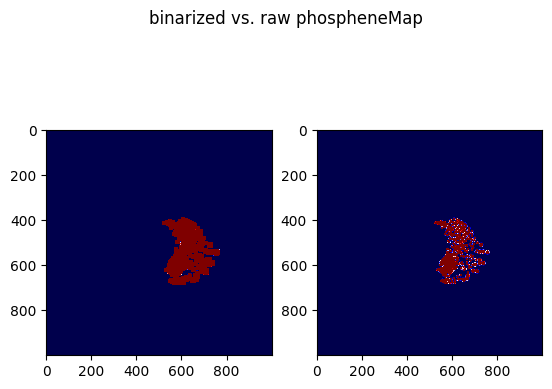

    max phospheneMap:  0.00046683554
target:  targ-full
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.72 0.12 0.58 0.90 True
     2.66 0.17 0.55 0.88 True
     3.67 0.02 0.19 0.96 False
     3.55 0.07 0.43 0.91 False
     2.75 0.11 0.40 0.90 True
     3.62 0.04 0.23 0.94 False
     3.54 0.07 0.49 0.91 False
     2.90 0.03 0.13 0.94 True
     2.84 0.06 0.23 0.92 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.38 1.00 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.28 1.00 True
     3.60 0.04 0.47 0.94 False
     2.62 0.20 0.32 0.86 True
     2.57 0.22 0.56 0.85 True
     3.55 0.07 0.45 0.92 False
     3.54 0.08 0.54 0.92 False
     2.69 0.14 0.57 0.88 True
     3.59 0.06 0.19 0.93 False
     2.85 0.05 0.27 0.93 True
     2.82 0.06 0.48 0.92 True
     2.71 0.13 0.53 0.90 True
map is nan or 0
Hellington is nan or inf
     3.75 0.00 0.01 1.00 False
     3.70 0.01 0.23 0.98 False
     3.56 0.07 0.40 0.92 False
     2.77 0.09 0.51 0.91 True
     2.70 0.14 0.52 0.8

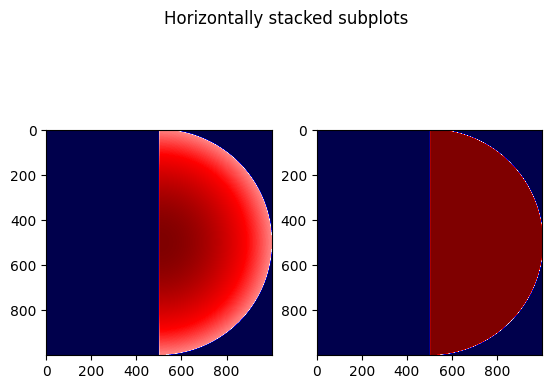

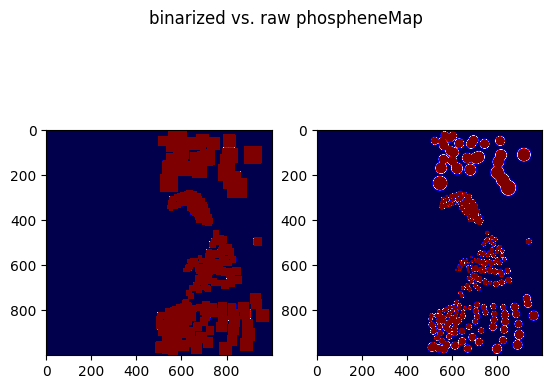

    max phospheneMap:  9.133872e-05
     2.69 0.15 0.54 0.90 True
     3.56 0.07 0.35 0.92 False
     2.92 0.01 0.44 0.98 True
     3.61 0.06 0.19 0.93 False
     3.64 0.04 0.16 0.94 False
     2.72 0.12 0.46 0.89 True
     3.58 0.07 0.28 0.92 False
     2.70 0.15 0.42 0.88 True
     2.87 0.04 0.34 0.94 True
     2.77 0.09 0.33 0.90 True
     2.78 0.11 0.27 0.92 True
     3.53 0.08 0.52 0.91 False
     2.96 0.01 0.20 0.98 True
     3.43 0.16 0.46 0.88 False
     2.68 0.16 0.45 0.88 True
map is nan or 0
Hellington is nan or inf
     3.73 0.00 0.17 1.00 False
     2.83 0.06 0.40 0.93 True
     2.86 0.06 0.04 0.93 True
     3.60 0.05 0.42 0.94 False
     2.63 0.20 0.39 0.87 True
     3.51 0.10 0.45 0.90 False
     2.39 0.36 0.56 0.81 True
     2.36 0.39 0.57 0.80 True
     2.30 0.43 0.59 0.79 True
     2.28 0.45 0.60 0.79 True
     2.97 0.00 0.15 0.99 True
     2.29 0.45 0.58 0.79 True
     2.28 0.44 0.59 0.78 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.34 1.00 True
   

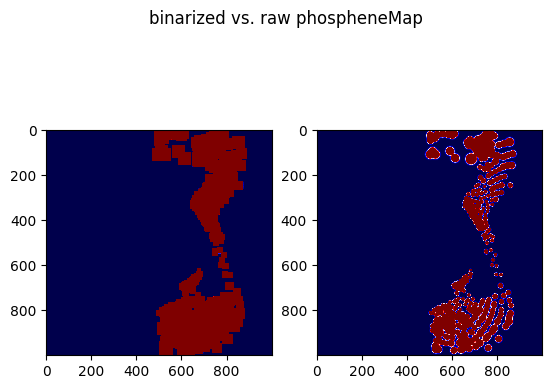

    max phospheneMap:  0.00010420422
target:  targ-full
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.72 0.13 0.48 0.90 True
     3.60 0.05 0.29 0.93 False
     2.81 0.07 0.34 0.92 True
     3.64 0.03 0.26 0.95 False
     2.81 0.06 0.47 0.92 True
     3.58 0.06 0.32 0.92 False
     2.79 0.09 0.30 0.91 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.42 1.00 False
     3.49 0.10 0.55 0.90 False
     2.80 0.06 0.54 0.92 True
     3.62 0.05 0.15 0.94 False
     3.67 0.00 0.52 0.98 False
     2.77 0.09 0.51 0.91 True
     3.64 0.03 0.38 0.96 False
     2.81 0.08 0.28 0.91 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.44 1.00 False
     2.81 0.07 0.40 0.92 True
     3.52 0.08 0.57 0.91 False
     2.73 0.12 0.42 0.89 True
     2.82 0.06 0.43 0.92 True
     2.84 0.05 0.42 0.93 True
     3.65 0.02 0.32 0.96 False
     2.84 0.04 0.57 0.93 True
     3.62 0.03 0.49 0.95 False
     2.65 0.18 0.45 0.87 True
     2.81 0.07 0.47 0.92 True
     2.22 0.50 0.54 0.77 True
   

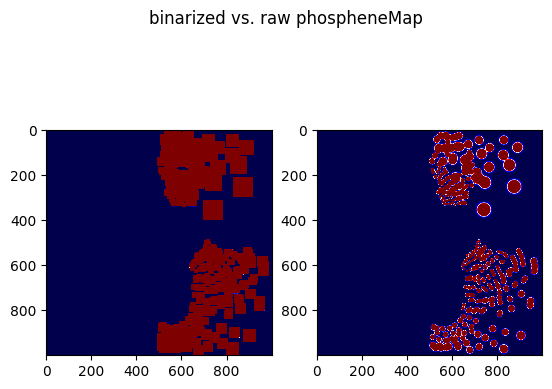

    max phospheneMap:  0.0001492189
     2.76 0.11 0.45 0.91 True
     2.60 0.23 0.23 0.86 True
     2.90 0.02 0.45 0.96 True
     2.84 0.05 0.35 0.93 True
     3.62 0.04 0.25 0.94 False
     3.63 0.04 0.29 0.94 False
     3.62 0.04 0.33 0.94 False
     3.66 0.03 0.15 0.95 False
     3.68 0.01 0.31 0.97 False
     2.85 0.05 0.39 0.94 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.35 1.00 True
     2.61 0.21 0.38 0.86 True
     2.86 0.04 0.39 0.94 True
     3.67 0.02 0.13 0.96 False
map is nan or 0
Hellington is nan or inf
     3.72 0.00 0.32 1.00 False
     3.66 0.02 0.24 0.96 False
     2.53 0.28 0.29 0.84 True
     2.52 0.28 0.31 0.84 True
     2.49 0.31 0.33 0.83 True
map is nan or 0
Hellington is nan or inf
     3.73 0.00 0.22 1.00 False
     2.77 0.12 0.13 0.90 True
     2.42 0.34 0.46 0.81 True
     2.39 0.37 0.44 0.80 True
     2.89 0.03 0.35 0.95 True
     2.39 0.37 0.41 0.80 True
     3.66 0.02 0.22 0.95 False
     2.53 0.27 0.36 0.83 True
     2.80 0.06 0.59 0

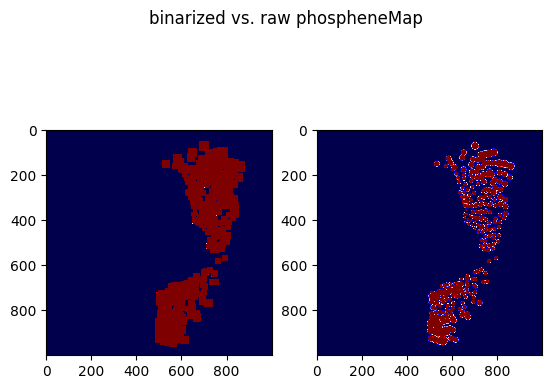

    max phospheneMap:  0.00018788969


In [8]:
###################
## Main Sim Loop ##
###################

# set file names
fname_ang = 'inferred_angle.mgz'
fname_ecc = 'inferred_eccen.mgz'
fname_sigma = 'inferred_sigma.mgz'
fname_anat = 'T1.mgz'
fname_aparc = 'aparc+aseg.mgz'
fname_label = 'inferred_varea.mgz'
print('number of subjects: ' + str(len(subj_list)))

# set beta angle constraints according to hemisphere
dim2_lh = Integer(name='beta', low=-15, high=110)
dim2_rh = Integer(name='beta', low=-110, high=15)

# loop through phosphene target maps and combinations of loss terms
for target_density, ftarget in zip(targ_comb, targ_names):
    for (a, b, c), floss in zip(loss_comb, loss_names):
        # set target
        target_density /= target_density.max()
        target_density /= target_density.sum()
        # can we relate bin_thesh to an eccentricity value?
        bin_thresh=np.percentile(target_density, dc_percentile ) #np.min(target_density) # bin_thesh determines size target
        target_density_bin = (target_density > bin_thresh).astype(bool)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        plt.subplot(1,2,1).imshow(target_density, cmap = 'seismic')
        plt.subplot(1,2,2).imshow(target_density_bin, cmap = 'seismic')

        for s in subj_list:
            data_dir = datafolder + str(s)+ '/T1w/' + str(s) + '/mri/'            
            if s == 'fsaverage':
                data_dir = datafolder + str(s) + '/mri/'
                
            # load maps
            ang_img = nib.load(data_dir+fname_ang)
            polar_map = ang_img.get_fdata()
            ecc_img = nib.load(data_dir+fname_ecc)
            ecc_map = ecc_img.get_fdata()
            sigma_img = nib.load(data_dir+fname_sigma)
            sigma_map = sigma_img.get_fdata()                
            aparc_img = nib.load(data_dir+fname_aparc)
            aparc_roi = aparc_img.get_fdata()
            label_img = nib.load(data_dir+fname_label)
            label_map = label_img.get_fdata()

            # compute valid voxels
            dot = (ecc_map * polar_map)
            good_coords = np.asarray(np.where(dot != 0.0))

            # filter gm per hemisphere
            cs_coords_rh = np.where(aparc_roi == 1021)
            cs_coords_lh = np.where(aparc_roi == 2021)
            gm_coords_rh = np.where((aparc_roi >= 1000) & (aparc_roi < 2000))
            gm_coords_lh = np.where(aparc_roi > 2000)
            xl,yl,zl = get_xyz(gm_coords_lh)
            xr,yr,zr = get_xyz(gm_coords_rh)
            GM_LH = np.array([xl,yl,zl]).T
            GM_RH = np.array([xr,yr,zr]).T

            # extract labels
            V1_coords_rh = np.asarray(np.where(label_map == 1))
            V1_coords_lh = np.asarray(np.where(label_map == 1))
            V2_coords_rh = np.asarray(np.where(label_map == 2))
            V2_coords_lh = np.asarray(np.where(label_map == 2))
            V3_coords_rh = np.asarray(np.where(label_map == 3))
            V3_coords_lh = np.asarray(np.where(label_map == 3))

            # divide V1 coords per hemisphere
            good_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            good_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V1_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V1_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V2_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V2_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V3_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V3_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T           

            # find center of left and right calcarine sulci
            median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
            median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]

            # get GM mask and compute dorsal/posterior planes
            gm_mask = np.where(aparc_roi != 0)
            print('target: ', ftarget)
            print('loss: ', floss)
            print('a,b,c: ', a,b,c)

            # apply optimization to each hemisphere
            for gm_mask, hem, start_location, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, dim2 in zip([GM_LH, GM_RH], ['LH', 'RH'], [median_lh, median_rh], [good_coords_lh, good_coords_rh], [V1_coords_lh, V1_coords_rh], [V2_coords_lh, V2_coords_rh], [V3_coords_lh, V3_coords_rh], [dim2_lh, dim2_rh]):        
                
                # check if already done
                data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget                
                fname = '/mnt/c/DATA/NESTOR/HCP/simresults/' + data_id + 'it' + str(iterr) + '.pkl'              
                if os.path.exists(fname):
                    print(str(s), ' ', str(hem), ' ',  str(ftarget), ' ', str(floss), ' already processed.')
                else:
                    dimensions = [dim1, dim2, dim3, dim4]

                    # create initial point generator
                    lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

                    # optimize
                    res = gp_minimize(f, x0=x0, dimensions=dimensions, n_jobs=-1, n_calls=num_calls, n_initial_points=num_initial_points, initial_point_generator=lhs2, callback=[custom_stopper])

                    # print results
                    print('subject ', s, ' ', hem)
                    print('best alpha:', res.x[0])
                    print('best beta:',res.x[1])
                    print('best offset_from_base:', res.x[2])
                    print('best shank_length:',res.x[3])
                    grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(res.x[0], res.x[1],res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density)
                    print('best dice, yield, KL: ', dice, grid_yield, hell_d)

                    # show resulting binary phosphene map (reflects dice coefficient)
                    bin_thresh=np.percentile(phospheneMap, dc_percentile) #np.min(target_density) # bin_thesh determines size target
                    phospheneMap_bin = (phospheneMap > bin_thresh).astype(bool)
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    fig.suptitle('binarized vs. raw phospheneMap')
                    plt.subplot(1,2,1).imshow(phospheneMap_bin, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.subplot(1,2,2).imshow(phospheneMap, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.show()
                    print('    max phospheneMap: ', np.max(phospheneMap))        

                    # Saving the objects
                    data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget                    
                    fname = outputfolder + data_id + '.pkl'
                    with open(fname, 'wb') as file:
                        pickle.dump([res, 
                                     grid_valid, 
                                     dice, hell_d, 
                                     grid_yield, 
                                     contacts_xyz_moved,
                                     good_coords,
                                     good_coords_V1,
                                     good_coords_V2,
                                     good_coords_V3,
                                     phosphenes,
                                     phosphenes_V1,
                                     phosphenes_V2,
                                     phosphenes_V3], file, protocol=-1)

In [ ]:
# from skopt.space import Space

# def plot_searchspace(x, title):
#     fig, ax = plt.subplots()
#     plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bo', label='samples')
#     plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bo', markersize=80, alpha=0.5)
#     # ax.legend(loc="best", numpoints=1)
#     ax.set_xlabel("X1")
#     ax.set_xlim([-5, 10])
#     ax.set_ylabel("X2")
#     ax.set_ylim([0, 15])
#     plt.title(title)
    
# n_samples = 10

# space = Space([(-5., 10.), (0., 15.)])
# x = lhs2.generate(space.dimensions, n_samples)
# plot_searchspace(x, 'classic LHS')
# pdist_data.append(pdist(x).flatten())
# x_label.append("lhs")